In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import keras

2024-12-01 14:45:43.209083: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 14:45:43.209512: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 14:45:43.212142: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 14:45:43.219497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733075143.232078    5417 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733075143.23

In [7]:
x_train = np.load('model/k49-train-imgs.npz')
y_train = np.load('model/k49-train-labels.npz')

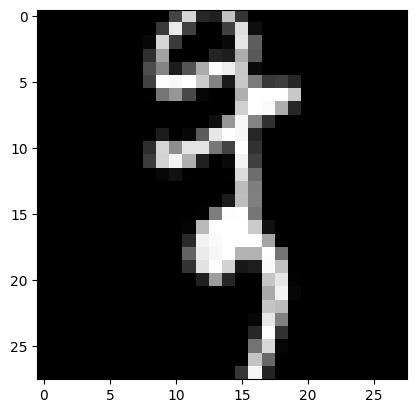

In [16]:
plt.imshow(x_train["arr_0"][0], cmap="grey")

In [13]:
y_train["arr_0"]

array([30, 19, 20, ..., 10, 39, 30], dtype=uint8)

In [5]:
model = keras.saving.load_model("model/kanji_model_350_epochs.hdf5")

In [ ]:
model.predict()